In [ ]:
#30k datasets 

import numpy as np
from Bio import SeqIO
import gzip
import os
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle

np.random.seed(454)


def load_data(path):
        
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number):
    
    
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
    
    
    
    r = 0    
    
   
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):

    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ' '.join(data_sources)     
    return data_sources, X


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
table_data = {}
dataset_list = ['KMER', 'RNA', 'RG', 'CLIP']
training_set_number = 0

# We have to generate combinations with differnet lengths, thus we generate length intigers and create sets with all combinations at given length.
for length in range(1,5):
    for set in itertools.combinations(dataset_list, length):

        average_score = np.zeros(len(protein_list))
        score_list = []

        for protein in protein_list:
           
            data_sources, X = load_data_sources(protein, 'train', training_set_number, *set)
            y = get_class(protein,"train",training_set_number)
            size = X.shape[2]
            score = []

            model = Sequential()
            model.add(Conv1D(60,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
            model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
            model.add(Conv1D(60, 4, activation='relu'))
            model.add(Dropout(0.2))
            model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
            model.add(Conv1D(60, 4, activation='relu'))
            model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
            model.add(Conv1D(60, 3, activation='relu'))
            model.add(GlobalAveragePooling1D())
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(2, activation='sigmoid'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
            earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

            X_train = X
            y_train = y

            metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

            #Run predictions on test dataset.
            data_sources, X_test = load_data_sources(protein, 'test', 0, *set)
            y_test = get_class(protein,"test",training_set_number)


            y_scores = model.predict(X_test)
            y_scores = y_scores [:,0:1]
            y_test = y_test [:,0:1]

            score = roc_auc_score(y_test, y_scores)

            
            score_list.append(score)
        
        print (protein)
        table_data[data_sources] = score_list
        
        with open('auc_combinations_results.pickle', 'wb') as f:
            pickle.dump(table_data, f, protocol=pickle.HIGHEST_PROTOCOL)



            

In [11]:
import pickle
import numpy as np
import pandas as pd

def highlight_max(s):
    is_max = s == max(s)
    return ['background-color: yellow' if v else '' for v in is_max]


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

with open('auc_combinations_results.pickle', 'rb') as f:
    loaded_table_data = pickle.load(f)

for dict_value in loaded_table_data:
    loaded_table_data[dict_value] = np.round(np.array(loaded_table_data[dict_value]),3)

loaded_table = pd.DataFrame(loaded_table_data, index = [i+1 for i in range (len(protein_list))])
loaded_table = loaded_table.T
loaded_table = loaded_table.reindex(sorted(loaded_table.columns), axis=1)

loaded_table.style.apply(highlight_max)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
CLIP,0.858,0.726,0.747,0.743,0.725,0.794,0.77,0.817,0.732,0.937,0.921,0.852,0.629,0.947,0.873,0.612,0.646,0.801,0.675,0.726,0.924,0.716,0.871,0.619,0.748,0.885,0.531,0.889,0.832,0.667,0.689
KMER,0.764,0.582,0.848,0.857,0.618,0.943,0.949,0.923,0.585,0.889,0.89,0.919,0.945,0.959,0.709,0.953,0.971,0.715,0.727,0.669,0.807,0.799,0.958,0.965,0.871,0.96,0.916,0.925,0.879,0.943,0.932
KMER CLIP,0.911,0.751,0.879,0.894,0.753,0.947,0.954,0.966,0.751,0.948,0.944,0.963,0.949,0.99,0.913,0.954,0.972,0.855,0.795,0.785,0.959,0.865,0.986,0.976,0.902,0.984,0.919,0.972,0.942,0.954,0.946
KMER RG,0.895,0.675,0.932,0.936,0.681,0.957,0.962,0.959,0.7,0.928,0.927,0.943,0.94,0.98,0.913,0.951,0.971,0.806,0.762,0.764,0.955,0.841,0.979,0.968,0.912,0.968,0.922,0.96,0.926,0.949,0.939
KMER RG CLIP,0.94,0.758,0.936,0.945,0.758,0.96,0.971,0.968,0.76,0.949,0.954,0.962,0.951,0.989,0.958,0.959,0.974,0.861,0.802,0.8,0.977,0.879,0.989,0.979,0.925,0.984,0.919,0.974,0.948,0.96,0.95
KMER RNA,0.789,0.584,0.851,0.854,0.619,0.943,0.953,0.932,0.592,0.898,0.897,0.923,0.94,0.962,0.773,0.954,0.972,0.72,0.725,0.673,0.855,0.818,0.964,0.966,0.884,0.962,0.923,0.929,0.886,0.943,0.928
KMER RNA CLIP,0.914,0.76,0.891,0.91,0.768,0.947,0.962,0.966,0.764,0.946,0.952,0.959,0.95,0.991,0.926,0.953,0.971,0.852,0.799,0.775,0.967,0.866,0.986,0.977,0.905,0.98,0.924,0.969,0.941,0.949,0.941
KMER RNA RG,0.906,0.688,0.942,0.942,0.68,0.967,0.972,0.957,0.714,0.93,0.931,0.942,0.942,0.983,0.926,0.956,0.97,0.808,0.773,0.771,0.958,0.858,0.982,0.974,0.918,0.963,0.917,0.964,0.93,0.947,0.942
KMER RNA RG CLIP,0.938,0.754,0.946,0.952,0.761,0.963,0.979,0.971,0.761,0.931,0.938,0.964,0.947,0.993,0.96,0.96,0.972,0.86,0.789,0.794,0.978,0.874,0.989,0.98,0.924,0.983,0.918,0.974,0.95,0.96,0.952
RG,0.842,0.638,0.849,0.845,0.615,0.86,0.902,0.744,0.6,0.872,0.877,0.724,0.583,0.858,0.864,0.623,0.612,0.693,0.622,0.635,0.913,0.763,0.882,0.58,0.842,0.668,0.632,0.82,0.775,0.69,0.68


AUC for KMER RG is 0.9 ± 0.02
AUC for KMER RNA CLIP is 0.91 ± 0.01
AUC for KMER RNA is 0.86 ± 0.02
AUC for CLIP is 0.77 ± 0.02
AUC for RNA RG is 0.77 ± 0.02
AUC for RNA is 0.59 ± 0.01
AUC for KMER RG CLIP is 0.92 ± 0.01
AUC for RNA CLIP is 0.8 ± 0.02
AUC for RG is 0.75 ± 0.02
AUC for KMER CLIP is 0.91 ± 0.01
AUC for KMER is 0.85 ± 0.02
AUC for KMER RNA RG is 0.91 ± 0.02
AUC for KMER RNA RG CLIP is 0.92 ± 0.01
AUC for RG CLIP is 0.84 ± 0.02
AUC for RNA RG CLIP is 0.84 ± 0.02


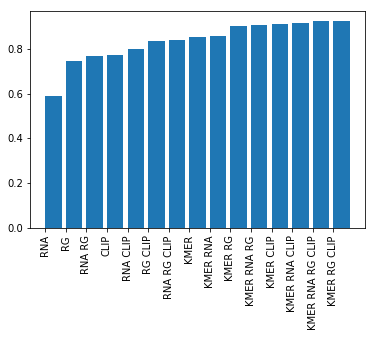

In [2]:
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import OrderedDict


with open('auc_combinations_results.pickle', 'rb') as f:
    loaded_table_data = pickle.load(f)
    for source in loaded_table_data.keys():
        std = stats.sem(loaded_table_data[source])
        loaded_table_data[source] = np.true_divide(sum(loaded_table_data[source]),31)
        print(u'AUC for {} is {} \u00B1 {}'.format(source, np.round(loaded_table_data[source], 2), np.round(std, 2)))
        

    sorted_data = OrderedDict(sorted(loaded_table_data.items(), key=lambda x: x[1]))
    
    plt.bar(sorted_data.keys(), sorted_data.values(), align='edge')
    plt.xticks(rotation='vertical')
    plt.show()
    

[1.0, 0.33118863745128146, 0.21514576019973314, 0.011190788889261581]
[0.33118863745128146, 1.0, 0.8582193942046666, 0.5125661515902644]
[0.21514576019973314, 0.8582193942046666, 1.0, 0.7279065068558596]
[0.011190788889261581, 0.5125661515902644, 0.7279065068558596, 1.0]
          KMER       RNA        RG      CLIP
KMER  1.000000  0.331189  0.215146  0.011191
RNA   0.331189  1.000000  0.858219  0.512566
RG    0.215146  0.858219  1.000000  0.727907
CLIP  0.011191  0.512566  0.727907  1.000000


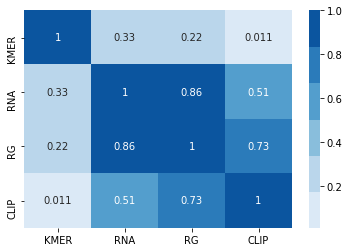

In [3]:
import pickle
import numpy as np
from scipy import stats
from scipy.stats.stats import pearsonr  
import pandas as pd
import itertools
import seaborn as sns

with open('auc_combinations_results.pickle', 'rb') as f:
    loaded_table_data = pickle.load(f)

    index = ['KMER' , 'RNA', 'RG', 'CLIP']
    df = pd.DataFrame(index = index)

    for source in index:
        correlation = [(pearsonr(loaded_table_data[source],loaded_table_data[s]))[0] for s in index]
        print(correlation)
        df1 = pd.DataFrame(correlation, index = index, columns =  [source])
        df = df.join(df1)

    print(df)

    h = sns.heatmap(df, cmap = sns.color_palette("Blues"), annot=True)


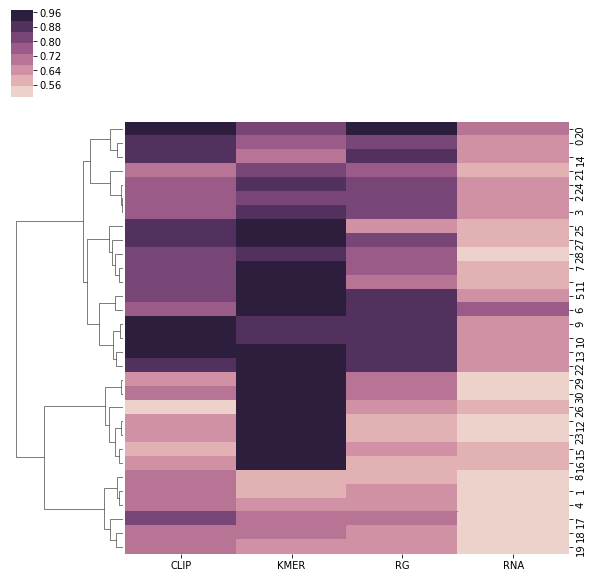

In [4]:
import seaborn as sns
individual_sources = np.zeros((4,31))
with open('auc_combinations_results.pickle', 'rb') as f:
    loaded_table_data = pickle.load(f)
    individual_sources = {k:loaded_table_data[k] for k in ['KMER' , 'RNA', 'RG', 'CLIP']}
    g = sns.clustermap(individual_sources, method = 'ward', col_cluster = False, cmap = sns.cubehelix_palette(8))